In [1]:
import pandas as pd
import numpy as np
import nmslib

%load_ext autoreload
%autoreload 2

from itertools import product
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
# init value: set -200 as out of range value
OUT_OF_RANGE_RSSI = -200.


# VBD DATA

In [2]:
beacons = ['Beacon00001', 'Beacon00002', 'Beacon00003', 'Beacon00004', 'Beacon00005', 'Beacon00006']
# beacons = ['Beacon00002', 'Beacon00003', 'Beacon00005', 'Beacon00006']
# beacons = ['Beacon00001', 'Beacon00003', 'Beacon00004', 'Beacon00006']

def preprocess_data(raw_data='training-vbd-floor3.json', beacons=beacons):
    rawdata_vbd_df = pd.read_json(raw_data)
    data = []
    row_data = []
    for cell in rawdata_vbd_df.data.beacons:
        row_data = []
        row_data.append(cell['Y'])
        row_data.append(cell['X'])
        for beacon in beacons:
            row_data.append(int(cell[beacon]))
        # drop 
        if OUT_OF_RANGE_RSSI in row_data:
            continue
        data.append(row_data)
    columns = ['col', 'row'] + beacons
    # convert to dataframe
    rssi_dataset_df = pd.DataFrame(data, columns=columns)
    return rssi_dataset_df

# convert to dataframe
rssi_dataset_df = preprocess_data()

In [3]:
# rssi_dataset_df = rssi_dataset_df[rssi_dataset_df.col<10]
# rssi_dataset_df = rssi_dataset_df[rssi_dataset_df.row<23]
# rssi_dataset_df = rssi_dataset_df[(rssi_dataset_df.row%2==0) | (rssi_dataset_df.row==0)]
# rssi_dataset_df = rssi_dataset_df[(rssi_dataset_df.col%2==1) | (rssi_dataset_df.col==0)]
rssi_dataset_df.describe()

,col,row,Beacon00001,Beacon00002,Beacon00003,Beacon00004,Beacon00005,Beacon00006
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,4.673077,10.336538,-76.480769,-72.432692,-74.326923,-74.903846,-72.798077,-71.336538
std,3.123485,6.786066,6.682800,5.140293,7.929841,6.263656,5.982791,5.397969
min,0.000000,0.000000,-93.000000,-87.000000,-88.000000,-86.000000,-82.000000,-81.000000
25%,2.000000,4.000000,-81.000000,-75.250000,-80.250000,-80.000000,-78.000000,-75.000000
50%,4.500000,10.000000,-77.000000,-73.000000,-75.000000,-76.000000,-73.000000,-72.000000
75%,8.000000,16.000000,-72.000000,-69.000000,-68.750000,-71.000000,-69.000000,-67.750000
max,9.000000,22.000000,-56.000000,-57.000000,-56.000000,-53.000000,-56.000000,-50.000000


## Split train set & test set

In [4]:
training_data = rssi_dataset_df.sample(frac=0.8, random_state=100)
testing_data = rssi_dataset_df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 83
No. of testing examples: 21


# Gaussian Processes Regression

x shape (83, 2)
x raw shape (104, 2)


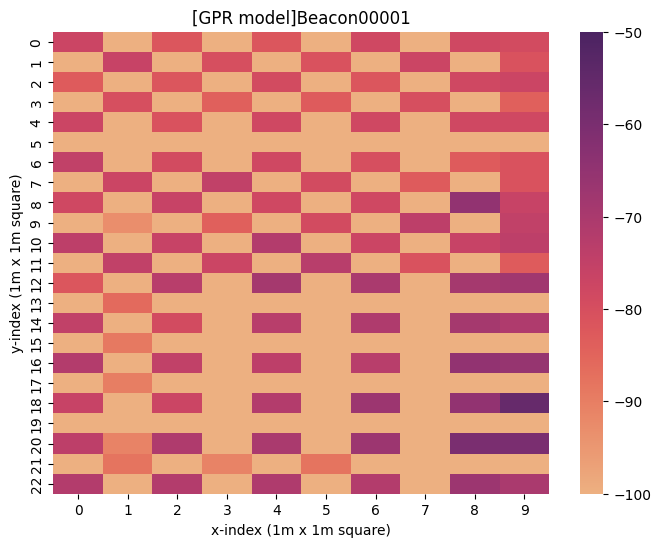

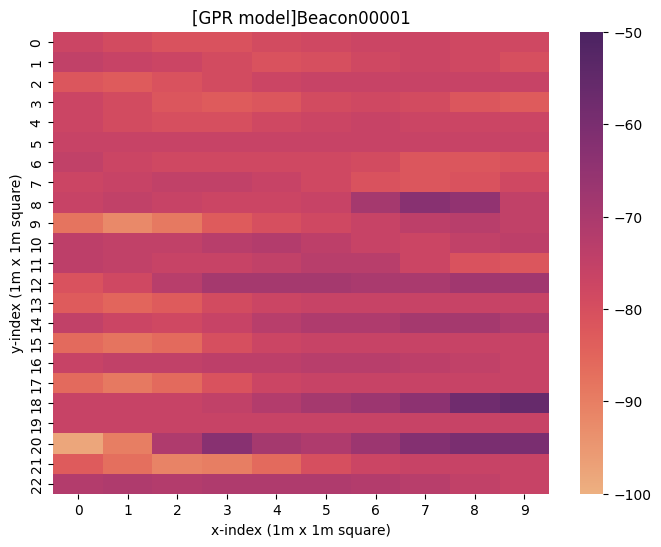

x shape (83, 2)
x raw shape (104, 2)


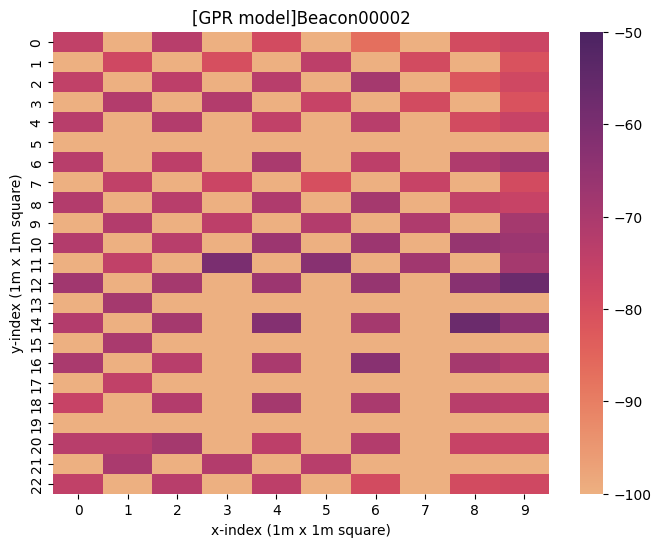

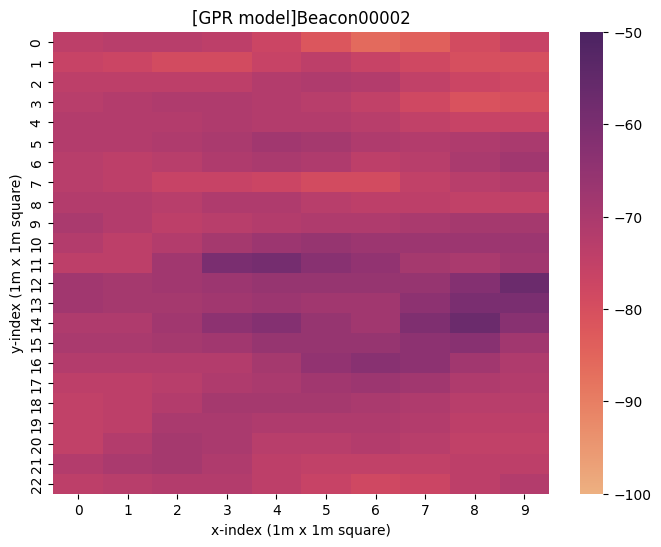

x shape (83, 2)
x raw shape (104, 2)


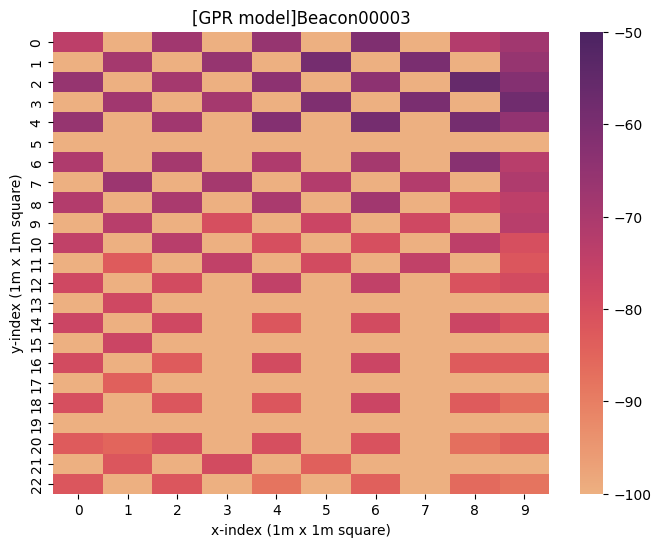

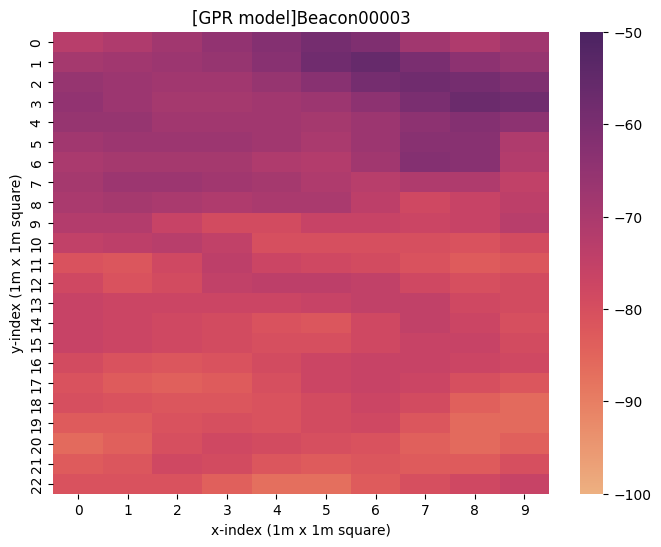

x shape (83, 2)
x raw shape (104, 2)


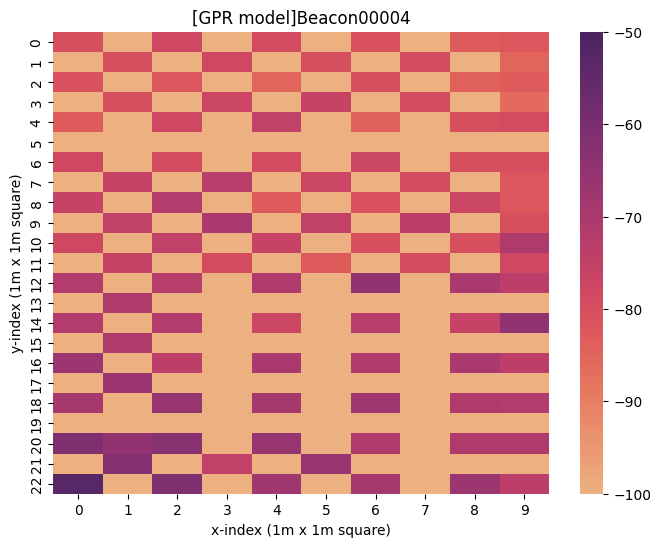

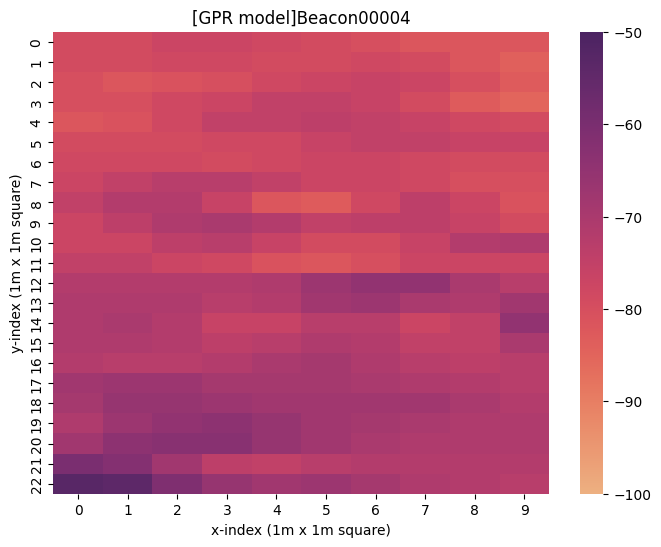

x shape (83, 2)
x raw shape (104, 2)


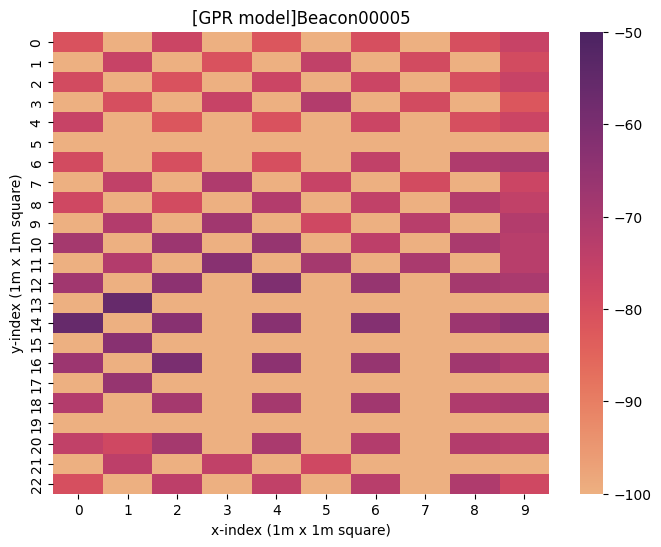

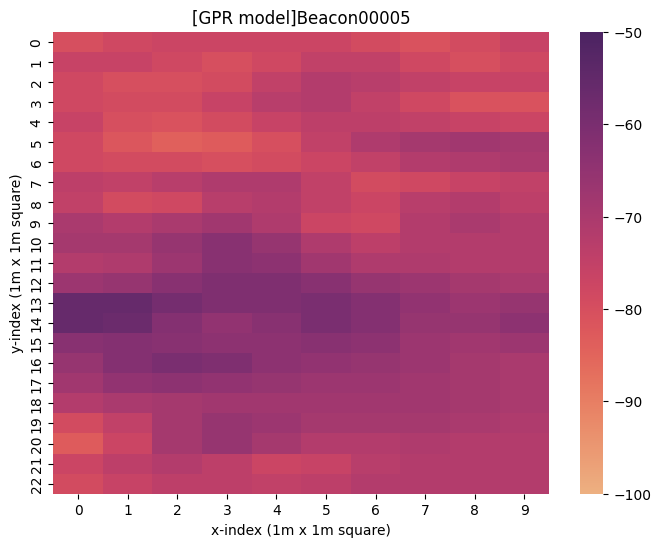

x shape (83, 2)
x raw shape (104, 2)


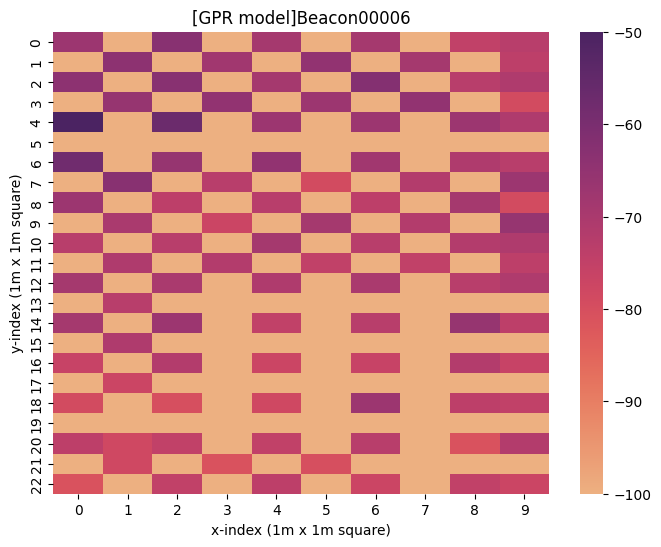

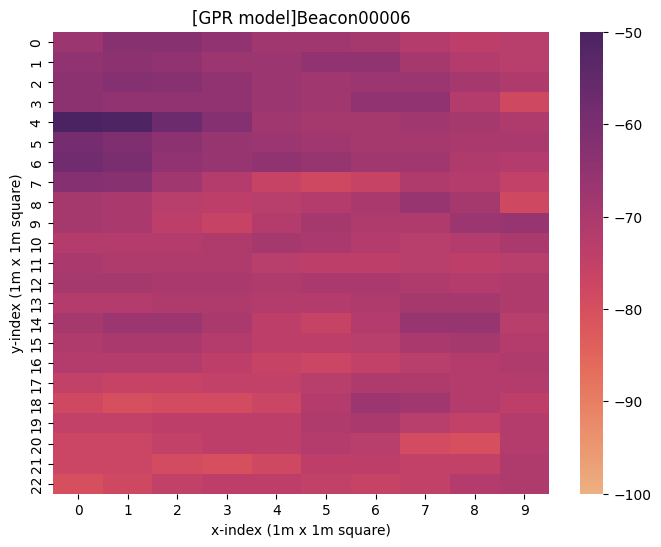

In [5]:
from helper import plot_radiomap

# init test matrix
n_rows = int(rssi_dataset_df.describe()['row']['max'])+1
n_cols = int(rssi_dataset_df.describe()['col']['max'])+1
radiomap = np.full((n_rows, n_cols), OUT_OF_RANGE_RSSI)
radiomap_raw = np.full((n_rows, n_cols), OUT_OF_RANGE_RSSI)
radiomaps = []

for beacon in beacons:
    # sample inputs and outputs
    X = training_data[['row', 'col']].to_numpy()
    Y = training_data[[beacon]].to_numpy()
    # standardscale
    X_scaler = preprocessing.StandardScaler().fit(X)
    Y_scaler = preprocessing.StandardScaler().fit(Y)
    # transform
    X_scaled = X_scaler.transform(X)
    Y_scaled = Y_scaler.transform(Y)

    # init kernel
    kernel = k.RBF(length_scale=[1., 1.], length_scale_bounds=(1e-2,1e2))
    # run GPR
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, normalize_y=True)
    gp.fit(X_scaled, Y_scaled.reshape(-1,1))
    
    # PLOT
    for i in range(n_rows):
        for j in range(n_cols):
            x_pred = X_scaler.transform(np.array([[i,j]]))
            y_mean,y_std = gp.predict(x_pred,return_std=True)
            radiomap[i, j] = int(Y_scaler.inverse_transform(np.array([y_mean])))
    # radiomap raw for visualizing
    X_raw = rssi_dataset_df[['row', 'col']].to_numpy()
    Y_raw = rssi_dataset_df[[beacon]].to_numpy()
    print('x shape', X.shape)
    print('x raw shape', X_raw.shape)
    radiomap_raw[X_raw[:,0],X_raw[:,1]] = Y_raw[:,0]

    plot_radiomap(radiomap_raw, min_data=-100, max_data=-50, beacon=beacon)
    plot_radiomap(radiomap, min_data=-100, max_data=-50, beacon=beacon)
    # [END] PLOT
    # add radiomap
    radiomaps.append(radiomap.flatten())

In [6]:
import helper

Test data (0,4): [-82 -79 -66 -79 -82 -69]
Test coord [106.66881031  10.81085449]
3 nearest neighbours (array idx): [13 14 36] [0.00010026 0.00017256 0.00017446]
3 nearest neighbours (fingerprints):
([[-79. -79. -66. -78. -80. -67.]
 [-81. -76. -63. -79. -78. -67.]
 [-78. -75. -64. -76. -75. -65.]])
Centroid cell: ([2.03315652 4.56925966])
Centroid coord: ([106.66881488  10.81084415])
Error: 1.5347201047895518


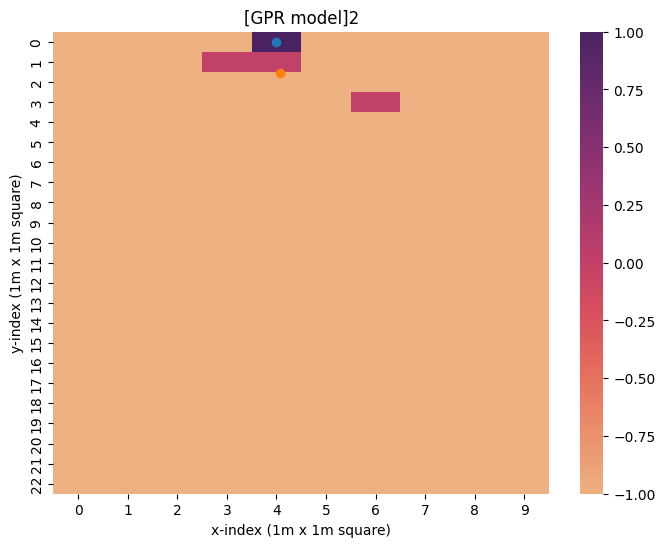

Test data (2,4): [-79 -73 -64 -85 -77 -69]
Test coord [106.66881561  10.81084075]
3 nearest neighbours (array idx): [25 24 26] [0.00048435 0.00058144 0.00058401]
3 nearest neighbours (fingerprints):
([[-76. -71. -63. -77. -72. -68.]
 [-77. -72. -66. -78. -75. -67.]
 [-76. -72. -59. -76. -73. -67.]])
Centroid cell: ([2.49999991 5.49862664])
Centroid coord: ([106.66882299  10.81084348])
Error: 0.9986266430449846


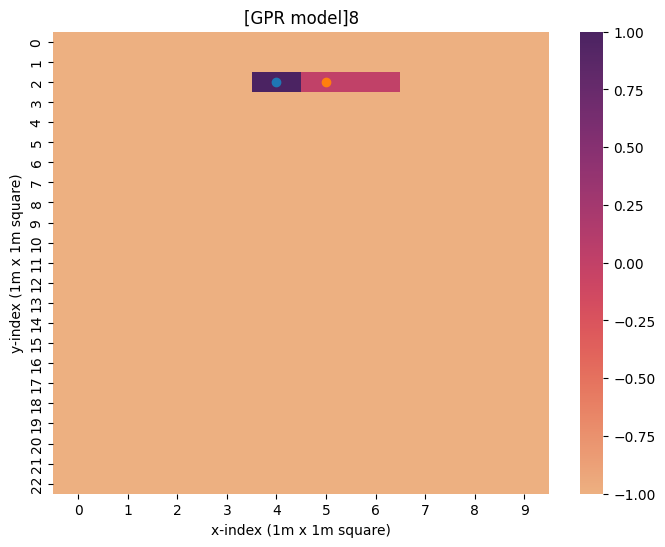

Test data (2,6): [-82 -69 -64 -80 -77 -62]
Test coord [106.6688304   10.81084621]
3 nearest neighbours (array idx): [21 20 22] [0.00023472 0.00029719 0.00041598]
3 nearest neighbours (fingerprints):
([[-83. -74. -67. -82. -80. -62.]
 [-82. -74. -66. -80. -78. -64.]
 [-81. -74. -68. -81. -80. -63.]])
Centroid cell: ([2.5        1.40418863])
Centroid coord: ([106.66879271  10.81083229])
Error: 5.095811374662228


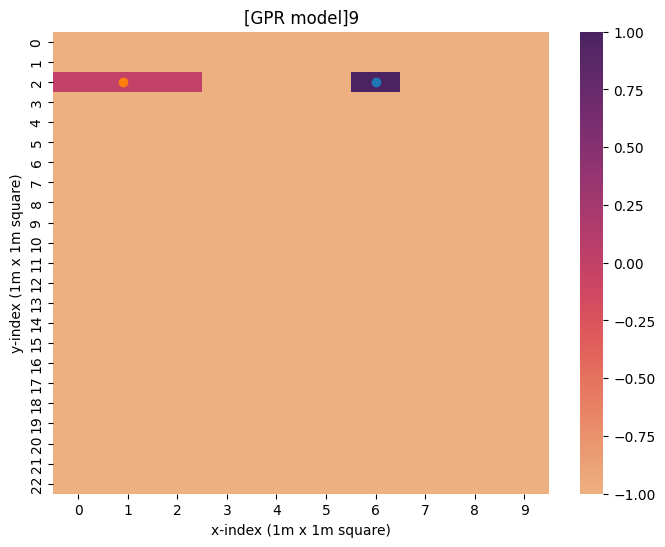

Test data (2,8): [-78 -82 -56 -84 -80 -73]
Test coord [106.66884518  10.81085168]
3 nearest neighbours (array idx): [38 39 28] [0.00028074 0.00052512 0.00052667]
3 nearest neighbours (fingerprints):
([[-82. -81. -57. -83. -81. -72.]
 [-83. -80. -58. -85. -81. -78.]
 [-76. -77. -59. -80. -76. -69.]])
Centroid cell: ([3.24219882 8.75856163])
Centroid coord: ([106.66884905  10.81084731])
Error: 0.7859473338637376


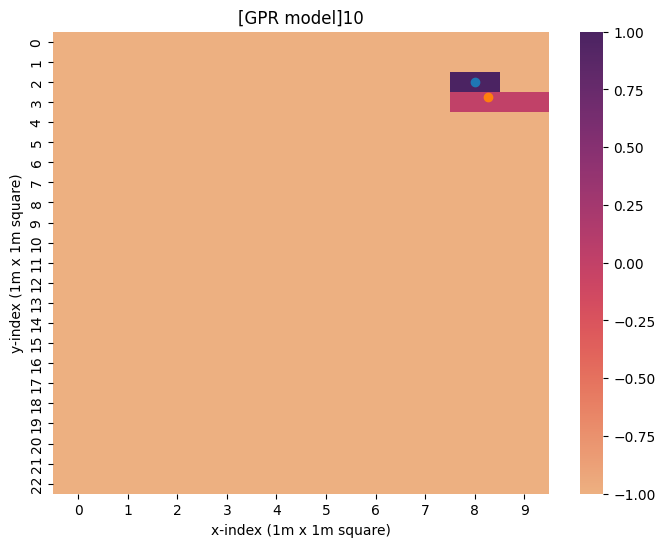

Test data (4,4): [-78 -75 -62 -75 -81 -67]
Test coord [106.6688209   10.81082701]
3 nearest neighbours (array idx): [13  4 14] [0.00036395 0.00045657 0.00045782]
3 nearest neighbours (fingerprints):
([[-79. -79. -66. -78. -80. -67.]
 [-79. -77. -62. -78. -77. -68.]
 [-81. -76. -63. -79. -78. -67.]])
Centroid cell: ([1.19247518 4.11420905])
Centroid coord: ([106.66880929  10.81084868])
Error: 3.3299482118796573


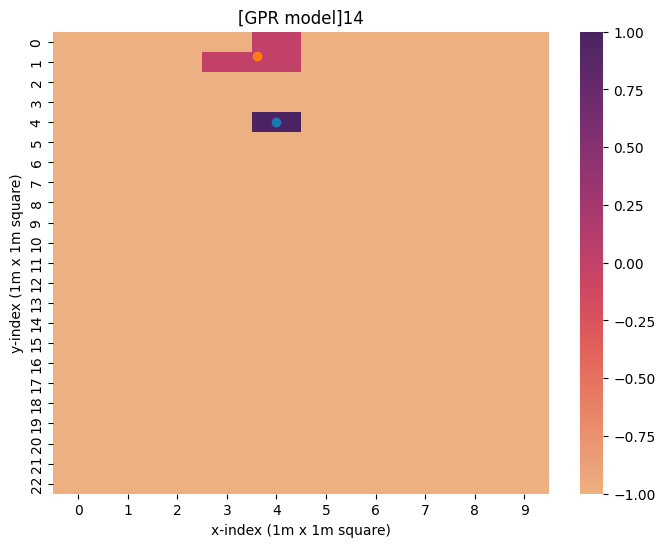

Test data (4,6): [-78 -73 -59 -84 -77 -67]
Test coord [106.66883567  10.8108325 ]
3 nearest neighbours (array idx): [15 28 26] [0.0004797  0.00062847 0.00066352]
3 nearest neighbours (fingerprints):
([[-80. -74. -58. -79. -75. -65.]
 [-76. -77. -59. -80. -76. -69.]
 [-76. -72. -59. -76. -73. -67.]])
Centroid cell: ([2.09778603 6.71178812])
Centroid coord: ([106.6688309   10.81084955])
Error: 2.4115319164412874


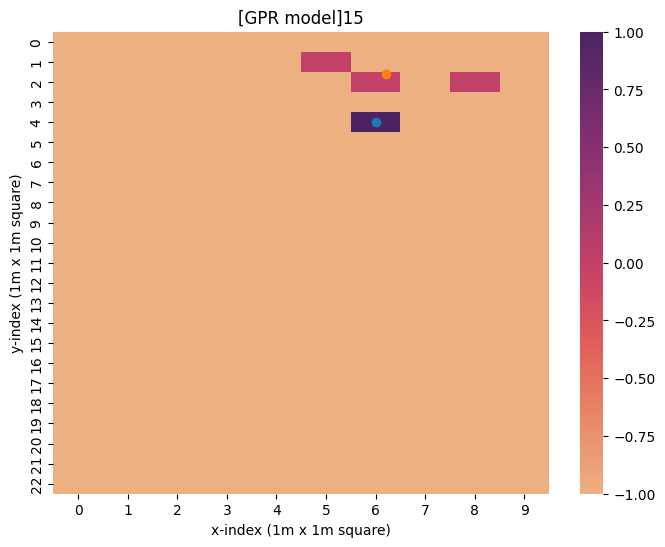

Test data (4,8): [-78 -79 -59 -80 -80 -67]
Test coord [106.66885044  10.81083799]
3 nearest neighbours (array idx): [37 17 27] [0.00013828 0.00016421 0.0002203 ]
3 nearest neighbours (fingerprints):
([[-79. -78. -60. -79. -78. -65.]
 [-77. -78. -60. -79. -78. -69.]
 [-76. -75. -58. -77. -75. -67.]])
Centroid cell: ([2.5639299 7.5      ])
Centroid coord: ([106.66883796  10.81084851])
Error: 2.179074904210473


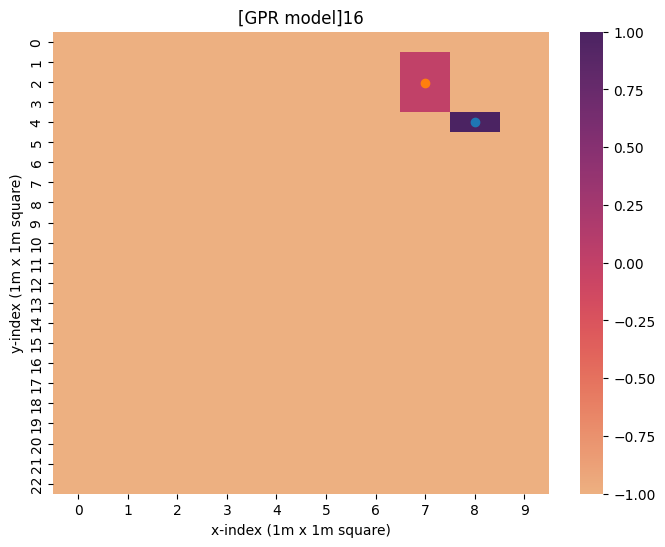

Test data (8,0): [-78 -72 -72 -76 -78 -67]
Test coord [106.66880201  10.81078845]
3 nearest neighbours (array idx): [65  0 55] [5.2213669e-05 1.5783310e-04 2.0307302e-04]
3 nearest neighbours (fingerprints):
([[-78. -71. -72. -77. -77. -66.]
 [-77. -74. -73. -79. -80. -67.]
 [-76. -69. -70. -76. -75. -68.]])
Centroid cell: ([5.08809458 4.45834524])
Centroid coord: ([106.66882215  10.81082285])
Error: 5.225858362636069


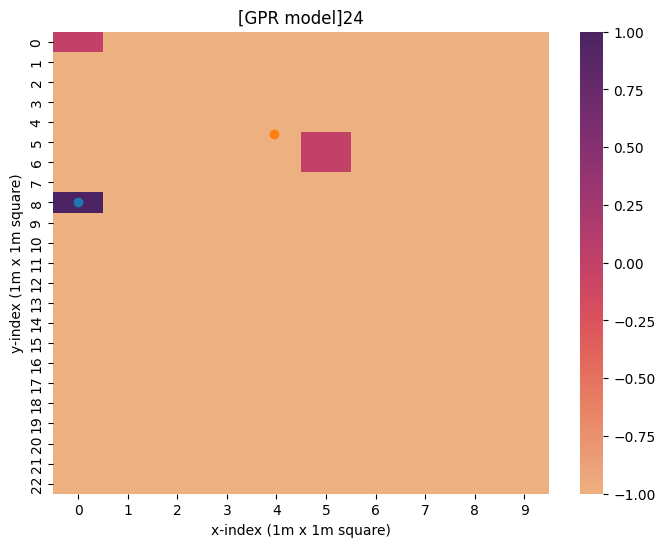

Test data (8,6): [-78 -69 -68 -81 -75 -74]
Test coord [106.66884622  10.81080506]
3 nearest neighbours (array idx): [84 85 78] [0.00030184 0.00044221 0.00044537]
3 nearest neighbours (fingerprints):
([[-77. -71. -70. -82. -72. -73.]
 [-76. -73. -70. -83. -75. -72.]
 [-81. -73. -71. -80. -76. -72.]])
Centroid cell: ([8.21286293 5.9377366 ])
Centroid coord: ([106.66884132  10.81080547])
Error: 0.6313381279496135


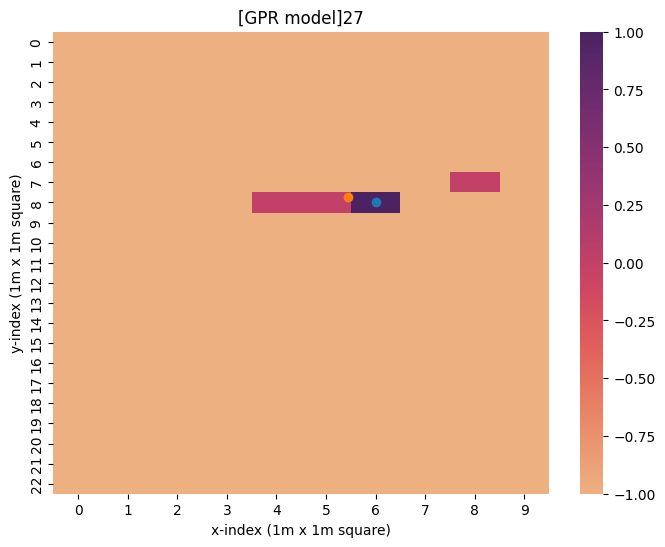

Test data (10,8): [-76 -66 -74 -80 -70 -72]
Test coord [106.66886621  10.8107969 ]
3 nearest neighbours (array idx): [ 79 157  69] [0.00044906 0.00047344 0.00048155]
3 nearest neighbours (fingerprints):
([[-78. -72. -75. -80. -75. -75.]
 [-76. -64. -76. -75. -67. -70.]
 [-81. -68. -72. -79. -70. -72.]])
Centroid cell: ([9.81010418 8.84155369])
Centroid coord: ([106.66886692  10.81080258])
Error: 0.7698150161942988


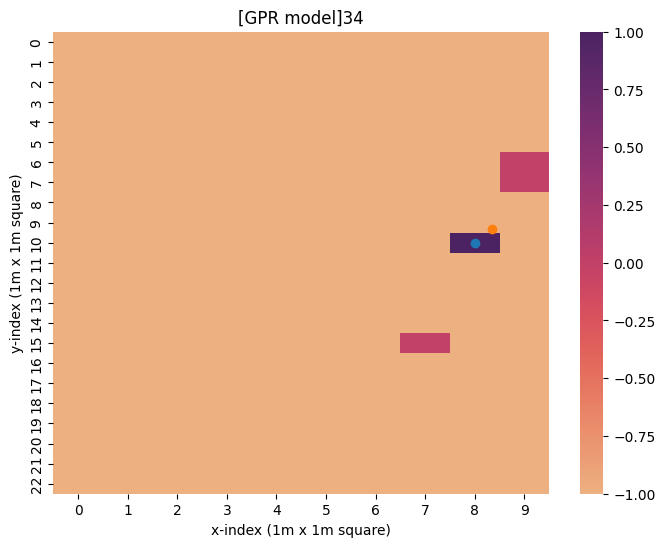

Test data (16,0): [-72 -70 -79 -67 -67 -76]
Test coord [106.66882331  10.81073328]
3 nearest neighbours (array idx): [184 182 183] [8.1181526e-05 2.0194054e-04 2.1880865e-04]
3 nearest neighbours (fingerprints):
([[-72. -69. -81. -68. -68. -77.]
 [-76. -72. -82. -66. -69. -79.]
 [-75. -69. -82. -67. -68. -79.]])
Centroid cell: ([18.5000004   3.83727312])
Centroid coord: ([106.66885309  10.81072893])
Error: 3.8906803395676444


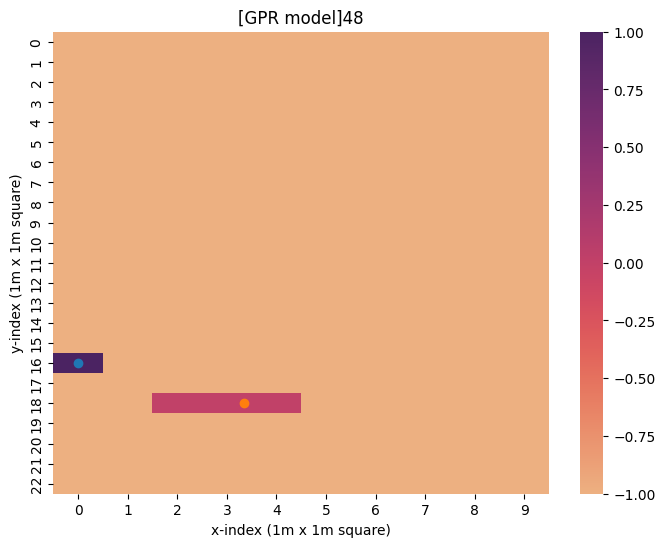

Test data (16,8): [-65 -69 -83 -70 -68 -72]
Test coord [106.66888199  10.81075582]
3 nearest neighbours (array idx): [206 187 185] [0.0004003  0.00043714 0.00057191]
3 nearest neighbours (fingerprints):
([[-67. -72. -81. -70. -72. -73.]
 [-64. -71. -79. -68. -68. -68.]
 [-69. -69. -79. -68. -68. -72.]])
Centroid cell: ([19.26462009  6.58249786])
Centroid coord: ([106.66887521  10.81073146])
Error: 3.364511657473964


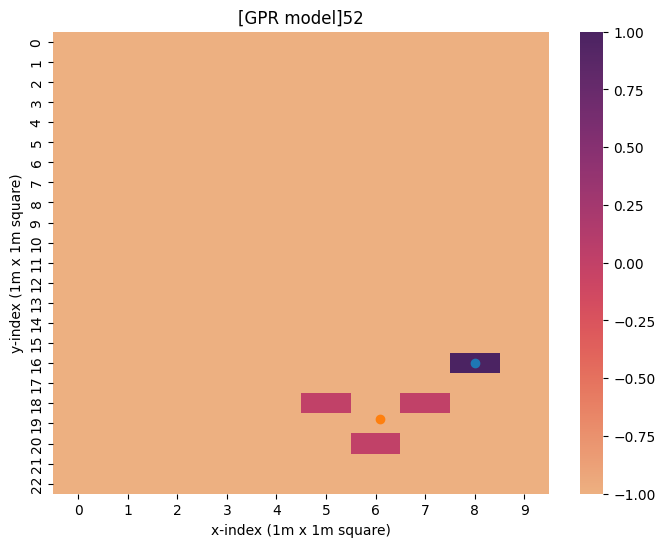

Test data (16,9): [-66 -72 -83 -74 -71 -76]
Test coord [106.66888932  10.81075864]
3 nearest neighbours (array idx): [206 187 207] [0.00034213 0.00052792 0.00054812]
3 nearest neighbours (fingerprints):
([[-67. -72. -81. -70. -72. -73.]
 [-64. -71. -79. -68. -68. -68.]
 [-62. -73. -84. -71. -71. -79.]])
Centroid cell: ([19.92957589  7.05990916])
Centroid coord: ([106.66888046  10.81072825])
Error: 4.209041944747243


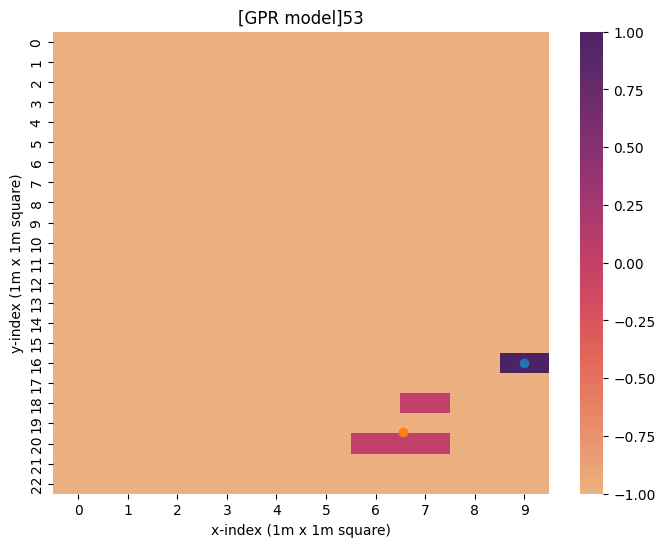

Test data (18,8): [-65 -73 -83 -71 -71 -74]
Test coord [106.66888724  10.81074213]
3 nearest neighbours (array idx): [206 187 207] [0.00017315 0.00021559 0.00050581]
3 nearest neighbours (fingerprints):
([[-67. -72. -81. -70. -72. -73.]
 [-64. -71. -79. -68. -68. -68.]
 [-62. -73. -84. -71. -71. -79.]])
Centroid cell: ([19.75130894  7.03390416])
Centroid coord: ([106.6688798  10.8107294])
Error: 1.927488280261113


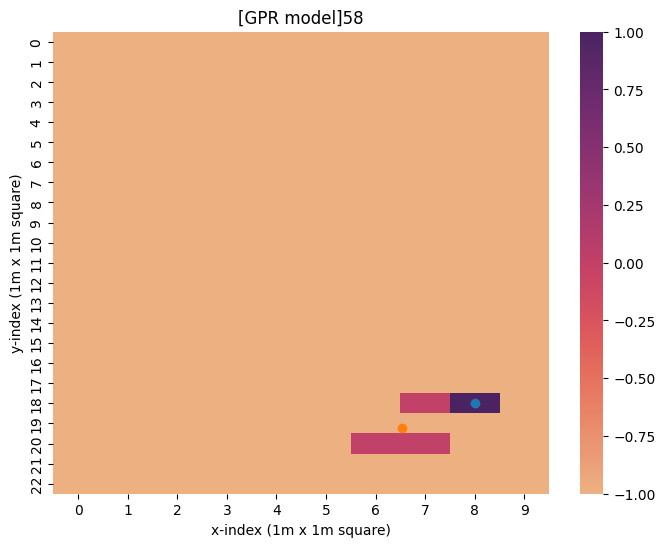

Test data (20,0): [-74 -73 -83 -61 -75 -74]
Test coord [106.66883397  10.8107057 ]
3 nearest neighbours (array idx): [222 191 223] [0.00010031 0.00042158 0.00056773]
3 nearest neighbours (fingerprints):
([[-72. -72. -81. -61. -74. -75.]
 [-76. -74. -83. -67. -75. -75.]
 [-71. -72. -84. -66. -74. -74.]])
Centroid cell: ([21.99538933  2.45669971])
Centroid coord: ([106.66885225  10.81070096])
Error: 2.4626942621783026


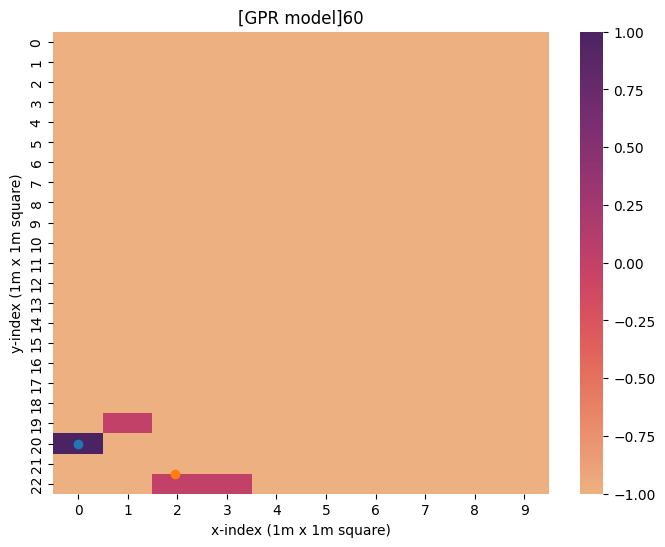

Test data (22,9): [-70 -78 -88 -74 -78 -77]
Test coord [106.66890507  10.81071759]
3 nearest neighbours (array idx): [206 187 224] [0.00011742 0.00017256 0.00043797]
3 nearest neighbours (fingerprints):
([[-67. -72. -81. -70. -72. -73.]
 [-64. -71. -79. -68. -68. -68.]
 [-71. -74. -87. -68. -75. -74.]])
Centroid cell: ([20.07673492  6.57404512])
Centroid coord: ([106.66887729  10.81072586])
Error: 3.7991348455954257


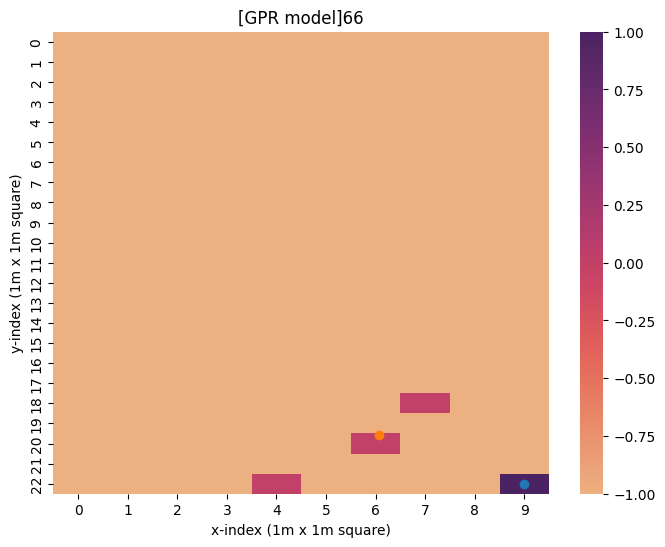

Test data (22,8): [-67 -79 -86 -67 -71 -75]
Test coord [106.66889776  10.81071474]
3 nearest neighbours (array idx): [225 226 203] [0.000467   0.00057089 0.00060767]
3 nearest neighbours (fingerprints):
([[-71. -76. -87. -67. -74. -75.]
 [-72. -78. -83. -69. -72. -76.]
 [-63. -70. -78. -63. -66. -74.]])
Centroid cell: ([21.90575777  5.22201896])
Centroid coord: ([106.66887223  10.81070946])
Error: 3.3314086347090655


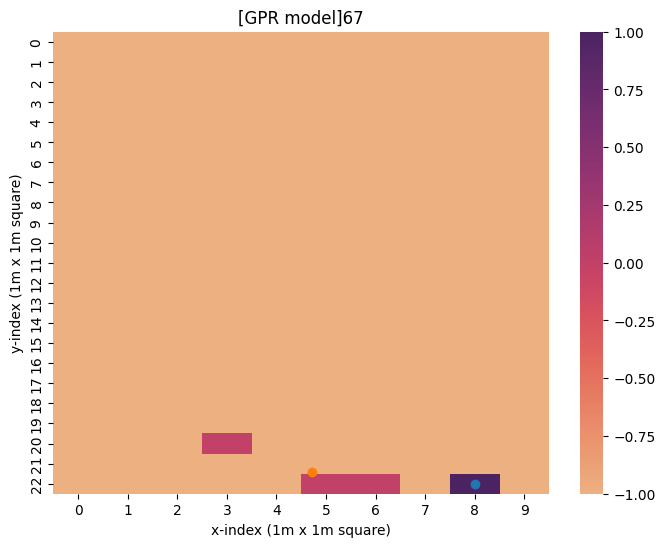

Test data (21,5): [-88 -73 -84 -66 -78 -80]
Test coord [106.66887319  10.81071304]
3 nearest neighbours (array idx): [211 201 210] [0.000144   0.00021684 0.00038511]
3 nearest neighbours (fingerprints):
([[-87. -70. -82. -62. -74. -77.]
 [-90. -72. -84. -64. -77. -77.]
 [-83. -72. -83. -60. -77. -77.]])
Centroid cell: ([21.17414632  1.31652152])
Centroid coord: ([106.66884173  10.81070337])
Error: 4.196149757598264


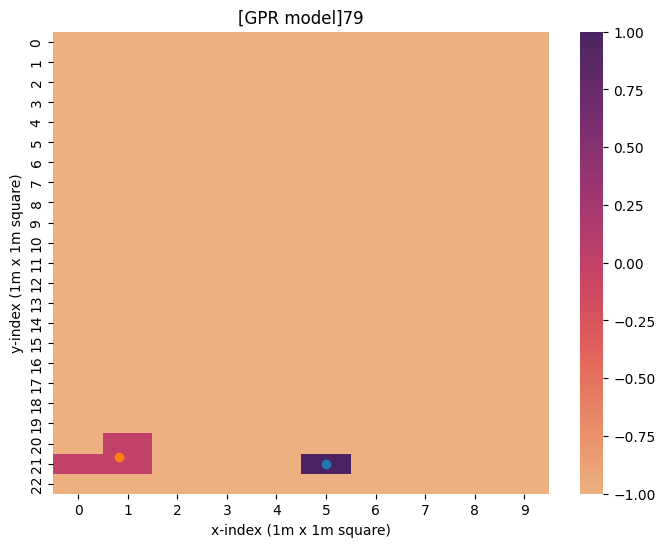

Test data (3,5): [-83 -76 -61 -76 -72 -67]
Test coord [106.66882564  10.81083662]
3 nearest neighbours (array idx): [67 14  4] [0.00025123 0.00062042 0.00066435]
3 nearest neighbours (fingerprints):
([[-82. -73. -62. -78. -72. -68.]
 [-81. -76. -63. -79. -78. -67.]
 [-79. -77. -62. -78. -77. -68.]])
Centroid cell: ([4.09202272 6.18246244])
Centroid coord: ([106.66883225  10.81083442])
Error: 0.903463270510795


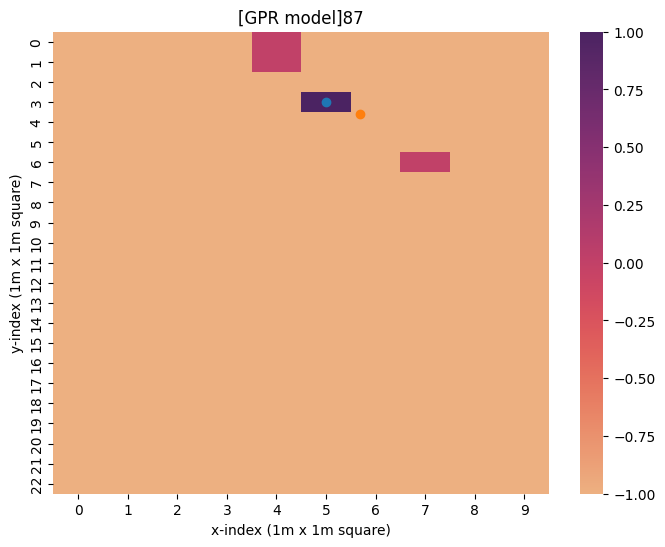

Test data (7,9): [-81 -79 -71 -82 -77 -67]
Test coord [106.6688657   10.81082021]
3 nearest neighbours (array idx): [11 70 71] [0.00013387 0.00016105 0.00018311]
3 nearest neighbours (fingerprints):
([[-76. -77. -68. -79. -76. -64.]
 [-77. -73. -69. -77. -74. -62.]
 [-76. -74. -67. -75. -75. -63.]])
Centroid cell: ([5.15840488 1.17559695])
Centroid coord: ([106.66879809  10.81081335])
Error: 8.647470956500332


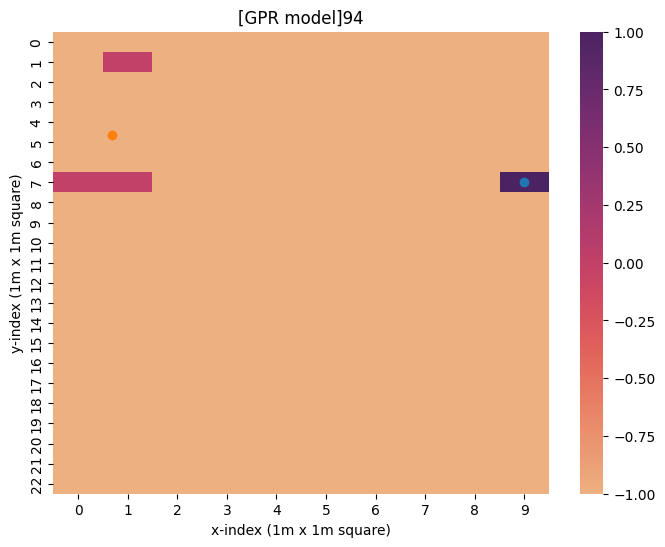

Test data (11,7): [-81 -68 -75 -79 -70 -75]
Test coord [106.66886149  10.81078727]
3 nearest neighbours (array idx): [ 69 157  59] [0.00018299 0.00040323 0.00053608]
3 nearest neighbours (fingerprints):
([[-81. -68. -72. -79. -70. -72.]
 [-76. -64. -76. -75. -67. -70.]
 [-76. -70. -71. -76. -69. -70.]])
Centroid cell: ([8.58502281 8.9944068 ])
Centroid coord: ([106.66886482  10.81081138])
Error: 3.27572033244616


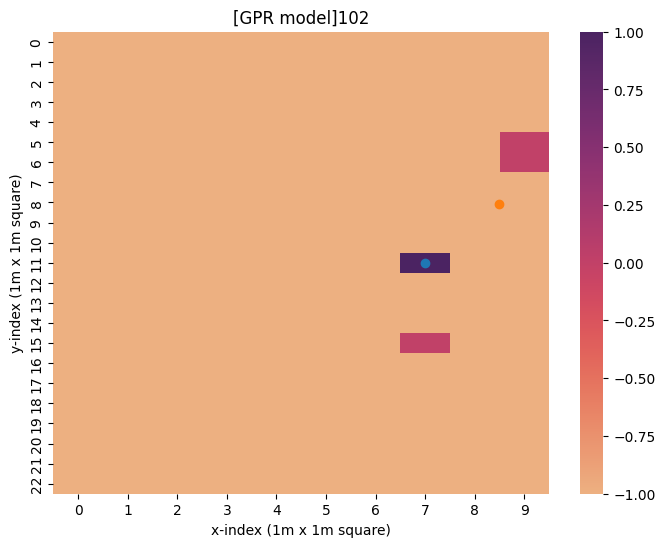

RMSE:  3.540977809865049


In [7]:
bounds = np.array([
    [106.66877566527455, 10.810845700675742],
    [106.66884972115128, 10.810872873012372],
    [106.66891003308865, 10.810715599882684],
    [106.66883697216787, 10.810687029981409]
    ])
helper.check_position_pred_accuracy(n_rows=n_rows, n_cols=n_cols,radiomaps=radiomaps, testing_data=testing_data, bounds=bounds)